# Regression analysis for assessing areas of deprivation

## Datasets

- Night lights imagery
- Shapefile of the local authorities of the UK
- Domestic and non-domestic electricity consumption
- Gross disposable household income
- Income and employment deprivation indices

## Regression analysis

- Night lights against electricity comsumption

- Night lights against Gross disposable household income

- Night lghts against deprivation indices

## Validation

The government of UK provides multiple deprivation index data in LSOA and LA level across UK.These datasets are regressed against night lights to examine their relationship


In [1]:
import os
import glob
import re

import rasterio
from rasterstats import zonal_stats
import numpy as np
import scipy
from scipy.stats import *
import statsmodels.api as sm
import pandas as pd
import geopandas as gpd

import matplotlib.pylab as plt
import seaborn as sns
sns.set()

import warnings
warnings.simplefilter('ignore', np.RankWarning)

/home/io/miniconda2/envs/geopython/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [2]:
DATA_PATH = '/home/io/ASTROSAT/code/night-lights/data'

### Load raster file - nightlights

In [3]:
data_path_nightlights = os.path.join(DATA_PATH,'night_lights_VIIRS_RGB_GB.tif')    

with rasterio.open(data_path_nightlights, 'r') as src:
    nightlights = src.read(6)
    nightlights_transform = src.transform

### Load vector file - LAD boundaries

In [4]:
lad_path = os.path.join(DATA_PATH,'lad','Local_Authority_Districts_2016_WGS84.shp')

# load the local authorities
lad = gpd.read_file(lad_path)
lad = lad.rename(columns={'lad16cd':'LAD code', 'lad16nm':'LAD name'}) 

# Choose only Local Authorities of England
lad_England = lad.loc[lad['LAD code'].str.contains('^E[0-9]{8}$')]
columns_to_drop = ['lad16nmw','bng_e','bng_n','long','lat','st_areasha','st_lengths']
lad_England = lad_England.drop(columns_to_drop, axis=1)

### Compute the sum of nightlights in each LA

In [5]:
stats_LAD_lights_sum = zonal_stats(lad_England, 
                                   nightlights,
                                   affine=nightlights_transform,
                                   stats=['sum'],
                                   nodata=-999 )                                                                                                                       

/home/io/miniconda2/envs/geopython/lib/python3.6/site-packages/rasterstats/main.py:165: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  np.issubdtype(fsrc.array.dtype, float)


### Attach the sum of nightlights to the dataframe

In [6]:
# nightlights sum for each local authority
LAD_lights_sum = [p['sum'] for p in stats_LAD_lights_sum]
lad_England['sum of night lights'] = LAD_lights_sum

gdf = lad_England.set_index('LAD code')

In [7]:
gdf.head()

,objectid,LAD name,geometry,sum of night lights
LAD code,,,,
E06000001,1,Hartlepool,(POLYGON ((-1.270251753363295 54.7271686841496...,3609.150007
E06000002,2,Middlesbrough,(POLYGON ((-1.230028686242537 54.5841083796549...,5895.076687
E06000003,3,Redcar and Cleveland,(POLYGON ((-1.137180612046189 54.6469456735212...,9893.049987
E06000004,4,Stockton-on-Tees,(POLYGON ((-1.31775721744014 54.64525078071659...,11519.706692
E06000010,10,"Kingston upon Hull, City of",(POLYGON ((-0.3161343125795458 53.813270163665...,7322.741647


In [8]:
RAW_DATA_PATH = '/home/io/ASTROSAT/code/uk-stats/data/raw'
ATTRIBUTES_DATA_PATH = os.path.join(RAW_DATA_PATH, 'attributes')

In [9]:
def select_and_rename_columns(df, columns, index_name=None):
    """ Select and rename columns in pandas.DataFrame
    
    Parameters
    ----------
    df: pandas Dataframe
        input data
    columns: dictionary
        Example: {'name beore':'name after'}
    index_name: string (optional)
        if provided, column named 'index_name' will be set as index.
    """
    df = df[list(columns.keys())]
    df = df.rename(columns=columns)
    if index_name:
        df = df.set_index(index_name)
    return df


### `Gross Value Added` and `Gross Disposable household income` data

In [10]:
def get_GVA(country='england'):
    """ Returns Gross Value Added data (millions) for each local authority
    
    Parameters
    ----------
    country: string
        Select country of interest: England, Wales or Scotland.
    """
    input_path = glob.glob(
        os.path.join(ATTRIBUTES_DATA_PATH, f'gva_lad_*{country}*'))[0]
    
    if country in ['england', 'wales','scotland']:
        df = pd.read_excel(input_path, sheet_name=2,skiprows=2)
        columns = {'LAU1 code' : 'LAD code',
                   2015 : 'GVA 2015(millions)'}              
    df = select_and_rename_columns(df, columns, 'LAD code')
    
    # Select rows of country
    area_code_letter = country[0].upper()
    area_code_regex = f'^{area_code_letter}[0-9]{{8}}$'
    df = df.loc[df.index.str.contains(area_code_regex, na=False)]
    
    return df

def get_GDHI(country='england'):
    """ Returns Gross Disposable Househol Income data (millions) for each local authority
    
    Parameters
    ----------
    country: string
        Select country of interest: England, Wales or Scotland.
    """
    input_path = glob.glob(
        os.path.join(ATTRIBUTES_DATA_PATH, f'gdhi_lad_*{country}*'))[0]
    
    if country in ['england', 'wales','scotland']:
        df = pd.read_excel(input_path, sheet_name=1,skiprows=2)
        columns = {'LAU1 code' : 'LAD code',
                   2015 : 'GDHI 2016(millions)'}              
    df = select_and_rename_columns(df, columns, 'LAD code')
    
    # Select rows of country
    area_code_letter = country[0].upper()
    area_code_regex = f'^{area_code_letter}[0-9]{{8}}$'
    df = df.loc[df.index.str.contains(area_code_regex, na=False)]

    return df

In [11]:
gva = get_GVA()
gdhi = get_GDHI()

### Electricity consumption data

In [12]:
def get_electricity_domestic_data(country='england'):
    """ Returns domestic electricity consumption data
    
    Parameters
    ----------
    country: string
        Select country of interest: England, Wales or Scotland.
    """
    input_path = glob.glob(
        os.path.join(ATTRIBUTES_DATA_PATH, f'electricity_domestic_lsoa_*{country}*'))[0]
    
    if country in ['england', 'wales','scotland']:
        df = pd.read_excel(input_path, sheet_name=1,skiprows=1)
        columns = {'Lower Layer Super Output Area (LSOA) Code': 'LSOA code',
                   'Local Authority Code' : 'LAD code',
                   'Total domestic electricity consumption (kWh)' : 'domestic_electricity_consumption(kwh)'
                   }              
    df = select_and_rename_columns(df, columns, 'LAD code')
    # replace dashes to zeros in the dataframe
    df = df.apply(lambda x: x.replace('-',0))
    # Convert dtype to integer so that we can do computations
    cols = ['domestic_electricity_consumption(kwh)']
    df[cols] = df[cols].apply(np.int64)
    
    df_grouped = df.groupby('LAD code')
    df_grouped_sum = df_grouped.sum()
    
    return df_grouped_sum

def get_electricity_nondomestic_data(country='england'):
    """ Returns non-domestic electricity consumption data
    
    Parameters
    ----------
    country: string
        Select country of interest: England, Wales or Scotland.
    """
    input_path = glob.glob(
        os.path.join(ATTRIBUTES_DATA_PATH, f'electricity_nondomestic_lsoa_*{country}*'))[0]
    
    if country in ['england', 'wales','scotland']:
        df = pd.read_excel(input_path, sheet_name=1,skiprows=1)
        columns = {'Local Authority Code' : 'LAD code',
                   ' Consumption (kWh) ' : 'nondomestic_electricity_consumption(kwh)'}              
    df = select_and_rename_columns(df, columns, 'LAD code')
    
    # impute missing values
    electricity_mean = df['nondomestic_electricity_consumption(kwh)'].mean()
    df['nondomestic_electricity_consumption(kwh)'].fillna(electricity_mean,inplace=True)
    
    df_grouped = df.groupby('LAD code')
    df_grouped_sum = df_grouped.sum()

    return df_grouped_sum

In [13]:
df_dom = get_electricity_domestic_data()
df_nondom = get_electricity_nondomestic_data()

### Deprivation indices data

In [14]:
def get_income_deprivation(country='england'):
    """ Returns income deprivation data
    
    Parameters
    -----------
    country: string
        Select country of interest: England, Wales or Scotland. At the moment,
        full datasets exist only for England
    """
    input_path = glob.glob(
        os.path.join(ATTRIBUTES_DATA_PATH, f'deprivation_lad_*{country}*'))[0]
    
    df = pd.read_excel(input_path, sheet_name=2)
    columns = {'Local Authority District code (2013)' : 'LAD code',
               'Income - Average rank' : 'Income - rank deprivation',
               'Income - Average score' : 'Income - score deprivation',
               'Income - Proportion of LSOAs in most deprived 10% nationally' : 'Income - proportion of the most deprived LSOAs',
               'Income - Scale' : 'Income - scale deprivation'
               }   
        
    df = select_and_rename_columns(df, columns, 'LAD code')
    # calculate percentage
    df['Income - score deprivation (%)'] = round(100 * df['Income - score deprivation'])
    df = df.drop('Income - score deprivation', axis=1)
    
    return df

def get_employment_deprivation(country='england'):
    """ Returns employment deprivation data
    
    Parameters
    -----------
    country: string
        Select country of interest: England, Wales or Scotland. At the moment,
        full datasets exist only for England
    """
    input_path = glob.glob(
        os.path.join(ATTRIBUTES_DATA_PATH, f'deprivation_lad_*{country}*'))[0]
    
    df = pd.read_excel(input_path, sheet_name=3)
    columns = {'Local Authority District code (2013)' : 'LAD code',
               'Employment - Average rank' : 'Employment rank deprivation',
               'Employment - Average score' : 'Employment - score deprivation',
               'Employment - Proportion of LSOAs in most deprived 10% nationally' : 'Employment - proportion of the most deprived LSOAs',
               'Employment - Scale' : 'Employment - scale deprivation'
               }   
        
    df = select_and_rename_columns(df, columns, 'LAD code')
    # calculate percentage
    df['Employment - score deprivation (%)'] = round(100 * df['Employment - score deprivation'])
    df = df.drop('Employment - score deprivation', axis=1)
    
    return df

def get_local_concentration(country='england'):
    """ Returns multiple deprivation of local concentration
    
    Parameters
    -----------
    country: string
        Select country of interest: England, Wales or Scotland. At the moment,
        full datasets exist only for England
    """
    input_path = glob.glob(
        os.path.join(ATTRIBUTES_DATA_PATH, f'deprivation_lad_*{country}*'))[0]
    
    df = pd.read_excel(input_path, sheet_name=1)
    columns = {'Local Authority District code (2013)' : 'LAD code',
               'IMD - Local concentration' : 'IMD - local concentration'
               }   
        
    df = select_and_rename_columns(df, columns, 'LAD code')
    
    return df

In [15]:
income_deprivation = get_income_deprivation()
employment_deprivation = get_employment_deprivation()
local_concentration = get_local_concentration()

In [16]:
## attributes to be concatinated to the Geo-dataframe
datasets = [income_deprivation, employment_deprivation, local_concentration, gva, gdhi,df_dom, df_nondom]

# Join all attributes to the Geo-dataframe
for data in datasets:
    gdf = gdf.join(data)

### Night lghts regressed against deprivation indices

Income - rank deprivation : 0.31122918379359016
Income - proportion of the most deprived LSOAs : 0.4043166527432695
Income - scale deprivation : 0.7796261202676662
Income - score deprivation (%) : 0.3582043103600182
Employment rank deprivation : 0.2737492314635973
Employment - proportion of the most deprived LSOAs : 0.3570386754151545
Employment - scale deprivation : 0.797551205236327
Employment - score deprivation (%) : 0.3068623877592516
IMD - local concentration : 0.33354668202530907


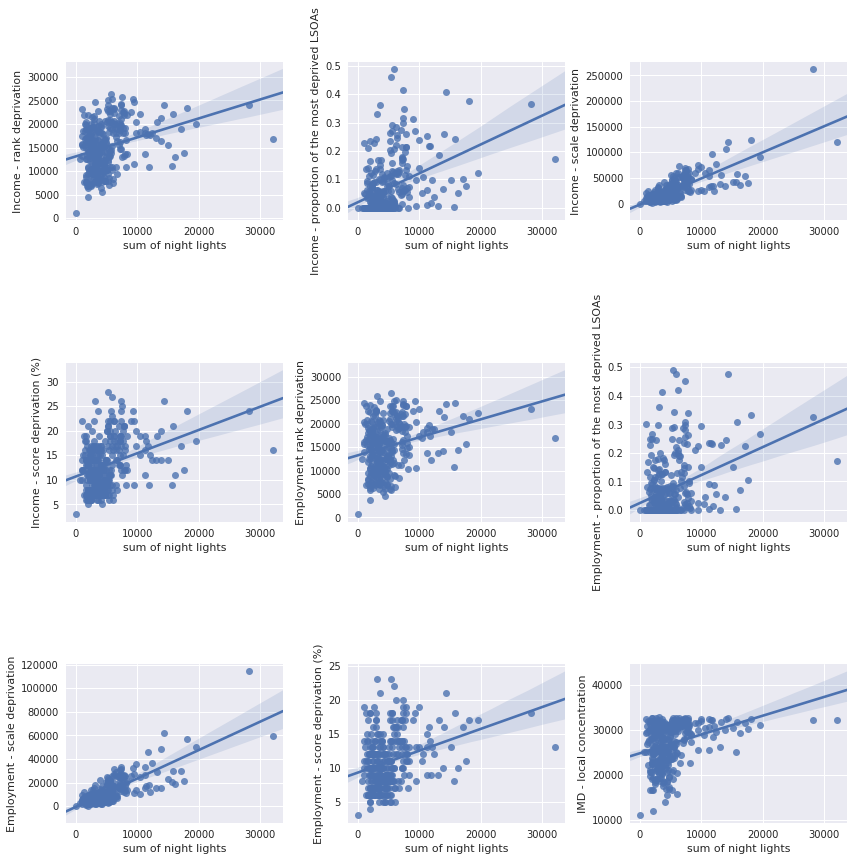

In [17]:
fig= plt.figure(figsize=(14,14))
deprivation_indices = [gdf['Income - rank deprivation'], gdf['Income - proportion of the most deprived LSOAs'], gdf['Income - scale deprivation'], 
                       gdf['Income - score deprivation (%)'],gdf['Employment rank deprivation'], gdf['Employment - proportion of the most deprived LSOAs'],
                       gdf['Employment - scale deprivation'], gdf['Employment - score deprivation (%)'], gdf['IMD - local concentration']]

# Select only columns assosiated with the regression plots
cols = gdf.columns[4:][:9]
for ax, (data, col) in enumerate(zip(deprivation_indices, cols)):
    # Estimate R squared
    poly_fit = scipy.polyfit(gdf['sum of night lights'], data , 1)
    poly_val = scipy.polyval(poly_fit, gdf['sum of night lights'])
    slope, intercept, r_value, p_value, std_error = linregress(gdf['sum of night lights'], data)
    print (col,':', r_value)
    
    ax = fig.add_subplot(3, 3, ax+1)
    sns.regplot(x=gdf['sum of night lights'], y=data, data=gdf, fit_reg=True)

fig.subplots_adjust(hspace=0.9, wspace=0.3)

### Night lights regressed against household income

GVA 2015(millions) : 0.4613300000826969
GDHI 2016(millions) : 0.6971936103242485


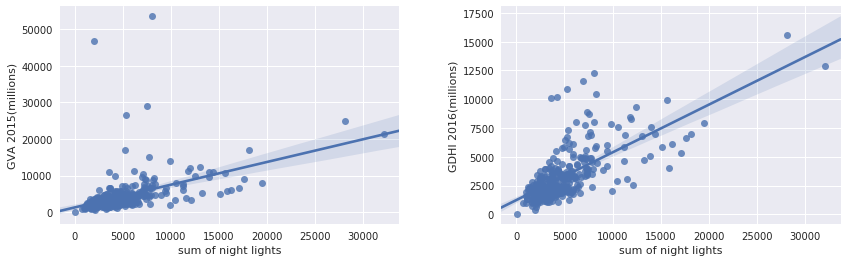

In [25]:
fig= plt.figure(figsize=(14,4))
household_income = [gdf['GVA 2015(millions)'], gdf['GDHI 2016(millions)']]

# Select only columns assosiated with the regression plots
cols = gdf.columns[-4:][:2]
for ax, (data, col) in enumerate(zip(household_income, cols)):
    # Estimate R squared
    poly_fit = scipy.polyfit(gdf['sum of night lights'], data , 1)
    poly_val = scipy.polyval(poly_fit, gdf['sum of night lights'])
    slope, intercept, r_value, p_value, std_error = linregress(gdf['sum of night lights'], data)
    print (col,':', r_value)
    
    ax = fig.add_subplot(1, 2, ax+1)
    sns.regplot(x=gdf['sum of night lights'], y=data, data=gdf, fit_reg=True)

fig.subplots_adjust(hspace=0.9, wspace=0.3)

## Find areas of low and high income based on quantiles

In [79]:
# First, we need to order the data from low to high
gdhi_ordered = gdf.sort_values(by='GDHI 2016(millions)')
gdhi_ordered = gdhi_ordered[['GDHI 2016(millions)','sum of night lights']]

# Calculate the threshold for low and upper quantiles
gdhi_quantile_lower = gdhi_ordered.quantile(q=0.25)[0]
gdhi_quantile_upper = gdhi_ordered.quantile(q=0.75)[0]

In [80]:
# Get the values that fall within the low and high income according to quantiles
lower_quantile = gdhi_ordered[(gdhi_ordered <= gdhi_quantile_lower).any(1)]
upper_quantile = gdhi_ordered[(gdhi_ordered >= gdhi_quantile_upper).any(1)]

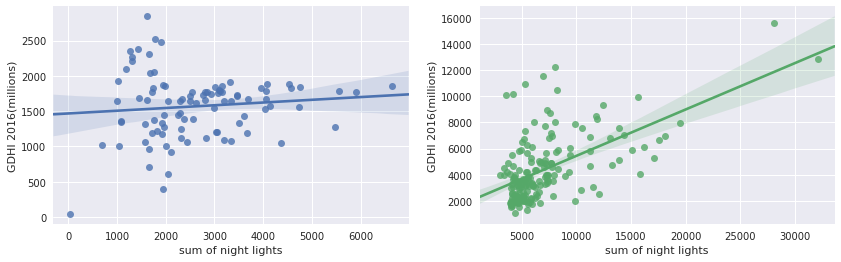

In [86]:
fig, axes = plt.subplots(ncols=2,figsize=(14,4))

sns.regplot(x='sum of night lights', y='GDHI 2016(millions)', data=lower_quantile, fit_reg=True, ax=axes[0])
sns.regplot(x='sum of night lights', y='GDHI 2016(millions)', data=upper_quantile, fit_reg=True, ax=axes[1])

### Night lghts regressed against electricity consumption

domestic_electricity_consumption(kwh) : 0.8450207186645614
nondomestic_electricity_consumption(kwh) : 0.7292691081077779


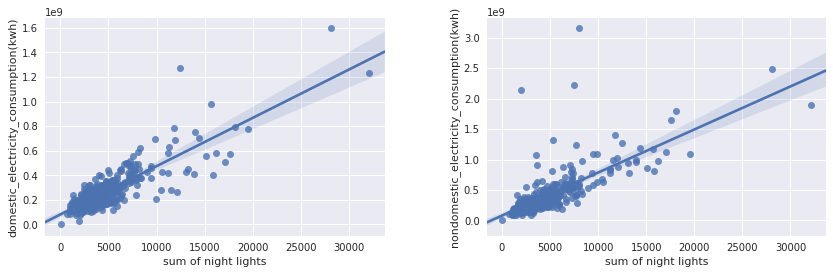

In [32]:
fig= plt.figure(figsize=(14,4))
electricity_consumption = [gdf['domestic_electricity_consumption(kwh)'], gdf['nondomestic_electricity_consumption(kwh)']]

# Select only columns assosiated with the regression plots
cols = gdf.columns[-2:]
for ax, (data, col) in enumerate(zip(electricity_consumption, cols)):
    # Estimate R squared
    poly_fit = scipy.polyfit(gdf['sum of night lights'], data , 1)
    poly_val = scipy.polyval(poly_fit, gdf['sum of night lights'])
    slope, intercept, r_value, p_value, std_error = linregress(gdf['sum of night lights'], data)
    print (col,':', r_value)
    
    ax = fig.add_subplot(1, 2, ax+1)
    sns.regplot(x=gdf['sum of night lights'], y=data, data=gdf, fit_reg=True)

fig.subplots_adjust(hspace=0.9, wspace=0.3)